# **DATA PROCESSING**

In [ ]:
import pandas as pd
from google.colab import files

# Upload Dataset
uploaded = files.upload()

Saving NBA-BoxScores-2023-2024.csv to NBA-BoxScores-2023-2024.csv


In [ ]:
import io

print(uploaded.keys())
df = pd.read_csv(io.BytesIO(uploaded['NBA-BoxScores-2023-2024.csv']))
print(df)

dict_keys(['NBA-BoxScores-2023-2024.csv'])
       Unnamed: 0   GAME_ID     TEAM_ID TEAM_ABBREVIATION    TEAM_CITY  \
0               0  22300061  1610612747               LAL  Los Angeles   
1               1  22300061  1610612747               LAL  Los Angeles   
2               2  22300061  1610612747               LAL  Los Angeles   
3               3  22300061  1610612747               LAL  Los Angeles   
4               4  22300061  1610612747               LAL  Los Angeles   
...           ...       ...         ...               ...          ...   
32383          22  22301189  1610612748               MIA        Miami   
32384          23  22301189  1610612748               MIA        Miami   
32385          24  22301189  1610612748               MIA        Miami   
32386          25  22301189  1610612748               MIA        Miami   
32387          26  22301189  1610612748               MIA        Miami   

       PLAYER_ID       PLAYER_NAME  NICKNAME START_POSITION COMMENT 

In [ ]:
# Look for missing values
data_info = df.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32388 entries, 0 to 32387
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         32388 non-null  int64  
 1   GAME_ID            32388 non-null  int64  
 2   TEAM_ID            32388 non-null  int64  
 3   TEAM_ABBREVIATION  32388 non-null  object 
 4   TEAM_CITY          32388 non-null  object 
 5   PLAYER_ID          32388 non-null  int64  
 6   PLAYER_NAME        32388 non-null  object 
 7   NICKNAME           32388 non-null  object 
 8   START_POSITION     12300 non-null  object 
 9   COMMENT            5987 non-null   object 
 10  MIN                26401 non-null  object 
 11  FGM                26401 non-null  float64
 12  FGA                26401 non-null  float64
 13  FG_PCT             26401 non-null  float64
 14  FG3M               26401 non-null  float64
 15  FG3A               26401 non-null  float64
 16  FG3_PCT            264

FILL IN MISSING VALUES AND CONVERT TO USABLE TYPES

In [ ]:
import numpy as np

# Fill missing values in 'COMMENT' and 'START_POSITION' with 'Unknown'
df['COMMENT'].fillna('Unknown', inplace=True)
df['START_POSITION'].fillna('Unknown', inplace=True)

# Fill missing stat values with 0
stat_cols = df.select_dtypes(include='float64').columns
df[stat_cols] = df[stat_cols].fillna(0)

# Convert MIN to Float
def convert_time_to_seconds(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        hours, minutes_seconds = time_str.split('.')
        minutes, seconds = minutes_seconds.split(':')
        return int(hours) * 60 + int(minutes) + int(seconds) / 60
    except ValueError:
        return np.nan

df['MIN'] = df['MIN'].apply(convert_time_to_seconds)

# Fill Nan values with 0.0
df['MIN'] = df['MIN'].fillna(0.0)


ADD OPPONENT TEAM STATISTICS

In [ ]:
# ADD OPPONENT_ID ATTRIBUTE
team_pairs = df.groupby('GAME_ID')['TEAM_ID'].unique().apply(lambda x: list(x) if len(x) == 2 else None)
opponent_map = {}
for game_id, teams in team_pairs.dropna().items():
    opponent_map[(game_id, teams[0])] = teams[1]
    opponent_map[(game_id, teams[1])] = teams[0]
df['OPPONENT_TEAM_ID'] = df.apply(lambda x: opponent_map.get((x['GAME_ID'], x['TEAM_ID'])), axis=1)
df[['GAME_ID', 'TEAM_ID', 'OPPONENT_TEAM_ID']].head()

#ADD OPPONENT AGGREGATES

# Aggregate the opponent's stats for each team's games
opponent_stats = df.groupby(['GAME_ID', 'OPPONENT_TEAM_ID']).agg({
    'PTS': 'sum',
    'REB': 'sum',
    'STL': 'sum',
    'BLK': 'sum',
    'PF': 'sum',
    'TO': 'sum',
    'FGA': 'sum',
    'FGM': 'sum'
}).reset_index()

opponent_stats.rename(columns={
    'PTS': 'PTS_OPP',
    'REB': 'REB_OPP',
    'STL': 'STL_OPP',
    'BLK': 'BLK_OPP',
    'PF': 'PF_OPP',
    'TO': 'TO_OPP',
    'FGA': 'FGA_OPP',
    "FGM": 'FGM_OPP'
}, inplace=True)

opponent_stats.rename(columns={'TEAM_ID': 'OPPONENT_TEAM_ID'}, inplace=True)

# Merge
df = df.merge(opponent_stats, left_on=['GAME_ID', 'OPPONENT_TEAM_ID'], right_on=['GAME_ID', 'OPPONENT_TEAM_ID'], suffixes=('', '_opp'))

#ADD FG_PCT_OPP and PACE
df['FG_PCT_OPP'] = df['FGM_OPP'] / df['FGA_OPP']
df['PACE'] = df['FGA'] + df['TO'] + df['FTA'] + df['OREB']



# Calculate correlations between each opponent defensive stat and player performance metrics
detailed_correlation_data = df[['PTS_OPP', 'REB_OPP', 'STL_OPP', 'BLK_OPP', 'PF_OPP', 'TO_OPP', 'FG_PCT_OPP',
                                'PTS', 'AST', 'REB', 'FG_PCT', 'TO', 'BLK', 'STL', 'PACE']].corr()
detailed_correlation_data.loc[['PTS_OPP', 'REB_OPP', 'STL_OPP', 'BLK_OPP', 'PF_OPP', 'TO_OPP', 'FG_PCT_OPP'],
                              ['PTS', 'AST', 'REB', 'FG_PCT', 'TO', 'BLK', 'STL', 'PACE']]



,PTS,AST,REB,FG_PCT,TO,BLK,STL,PACE
PTS_OPP,0.095951,0.080363,0.006441,0.108986,-0.049824,0.018326,0.003588,0.010985
REB_OPP,0.011230,0.005340,0.140584,-0.019469,0.026605,0.039722,-0.027782,0.043733
STL_OPP,0.002325,0.003019,-0.018154,0.000888,0.001545,-0.000180,0.239387,0.007797
BLK_OPP,0.006574,0.009378,0.019574,0.012334,0.010746,0.246091,-0.001449,0.000426
PF_OPP,0.010584,-0.006564,-0.004322,-0.005298,0.016975,-0.013681,-0.002983,0.015467
TO_OPP,-0.021159,-0.012361,0.017787,0.008933,0.215574,0.015379,0.003484,0.012409
FG_PCT_OPP,0.069698,0.077688,-0.028169,0.141485,-0.007224,0.015241,-0.011269,-0.033654


ADD TEAM STATISTICS

In [ ]:
# Aggregate the opponent's stats for each team's games
team_stats = df.groupby(['GAME_ID', 'TEAM_ID']).agg({
    'PTS': 'sum',
    'REB': 'sum',
    'STL': 'sum',
    'BLK': 'sum',
    'PF': 'sum',
    'TO': 'sum',
    'FGA': 'sum',
    'FGM': 'sum',
    'PACE': 'sum'
}).reset_index()

team_stats.rename(columns={
    'PTS': 'PTS_TEAM',
    'REB': 'REB_TEAM',
    'STL': 'STL_TEAM',
    'BLK': 'BLK_TEAM',
    'PF': 'PF_TEAM',
    'TO': 'TO_TEAM',
    'FGA': 'FGA_TEAM',
    'FGM': 'FGM_TEAM',
    'PACE': 'PACE_TEAM'
}, inplace=True)

# Merge
df = df.merge(team_stats, on=['GAME_ID', 'TEAM_ID'], suffixes=('', '_team'))

df['FG_PCT_TEAM'] = df['FGM_TEAM'] / df['FGA_TEAM']

# Calculate correlations between each opponent defensive stat and player performance metrics
detailed_correlation_data = df[['PTS_TEAM', 'REB_TEAM', 'STL_TEAM', 'BLK_TEAM', 'PF_TEAM', 'TO_TEAM', 'FG_PCT_TEAM', 'PACE_TEAM',
                                'PTS', 'AST', 'REB', 'FG_PCT', 'TO', 'BLK', 'STL', 'PACE']].corr()
detailed_correlation_data.loc[['PTS_TEAM', 'REB_TEAM', 'STL_TEAM', 'BLK_TEAM', 'PF_TEAM', 'TO_TEAM', 'FG_PCT_TEAM', 'PACE_TEAM'],
                              ['PTS', 'AST', 'REB', 'FG_PCT', 'TO', 'BLK', 'STL', 'PACE']]


,PTS,AST,REB,FG_PCT,TO,BLK,STL,PACE
PTS_TEAM,0.095951,0.080363,0.006441,0.108986,-0.049824,0.018326,0.003588,0.010985
REB_TEAM,0.011230,0.005340,0.140584,-0.019469,0.026605,0.039722,-0.027782,0.043733
STL_TEAM,0.002325,0.003019,-0.018154,0.000888,0.001545,-0.000180,0.239387,0.007797
BLK_TEAM,0.006574,0.009378,0.019574,0.012334,0.010746,0.246091,-0.001449,0.000426
PF_TEAM,0.010584,-0.006564,-0.004322,-0.005298,0.016975,-0.013681,-0.002983,0.015467
TO_TEAM,-0.021159,-0.012361,0.017787,0.008933,0.215574,0.015379,0.003484,0.012409
FG_PCT_TEAM,0.069698,0.077688,-0.028169,0.141485,-0.007224,0.015241,-0.011269,-0.033654
PACE_TEAM,0.025606,-0.009498,0.072504,-0.037706,0.030498,0.011685,0.027632,0.082126


INJURY ATTRIBUTE

In [ ]:
comment = df['COMMENT']

# Identify injured games
df['injured_game'] = comment.str.contains('DND')
df['injured_ma_5'] = df.groupby('PLAYER_ID')['injured_game'].transform(lambda x: x.rolling(window=5).sum())

# Make it a binary feature
df['injured_last_5'] = df['injured_ma_5'] > 0


# **CORRELATION EXPLORATION**

CONSISTENCY BY STAT CATEGORY

In [ ]:
consistency_by_category = {
    'Points': df['PTS'].std(),
    'Rebounds': df['REB'].std(),
    'Assists': df['AST'].std(),
    'Steals': df['STL'].std(),
    'Blocks': df['BLK'].std(),
    'Turnovers': df['TO'].std(),
    'Personal Fouls': df['PF'].std(),
    'Plus/Minus': df['PLUS_MINUS'].std()
}

mean_by_category = {
    'Points': df['PTS'].mean(),
    'Rebounds': df['REB'].mean(),
    'Assists': df['AST'].mean(),
    'Steals': df['STL'].mean(),
    'Blocks': df['BLK'].mean(),
    'Turnovers': df['TO'].mean(),
    'Personal Fouls': df['PF'].mean(),
    'Plus/Minus': df['PLUS_MINUS'].mean()
}

# Calculate Coefficient of Variation for each category (CV = std_dev / mean)
# This represents the variability of each category relative to the mean

cv_by_category = {key: consistency_by_category[key] / mean_by_category[key] if mean_by_category[key] != 0 else float('inf') for key in consistency_by_category}

cv_by_category

{'Points': 1.0493042909200994,
 'Rebounds': 1.0602019959793239,
 'Assists': 1.2787611079989714,
 'Steals': 1.563502365572383,
 'Blocks': 2.036139827640584,
 'Turnovers': 1.3485298857744326,
 'Personal Fouls': 1.0366750127901685,
 'Plus/Minus': inf}

CORRELATION MATRIX WITH BASIC STATS

In [ ]:
# CORRELATION MATRIX
selected_columns = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FGA', 'FG_PCT', 'FTM', 'FTA', 'FT_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'PLUS_MINUS', 'MIN', 'PTS_OPP', 'REB_OPP', 'STL_OPP', 'BLK_OPP', 'TO_OPP', 'PF_OPP', 'FG_PCT_OPP', 'PACE', 'PTS_TEAM', 'REB_TEAM', 'STL_TEAM', 'BLK_TEAM', 'PF_TEAM', 'TO_TEAM', 'FG_PCT_TEAM', 'PACE_TEAM', 'injured_last_5']
correlation_matrix = df[selected_columns].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Correlations with points scored
pts_correlations = correlation_matrix['PTS']
print("\nCorrelation with Points Scored:")
print(pts_correlations)

# Correlations with assists
ast_correlations = correlation_matrix['AST']
print("\nCorrelation with Assists:")
print(ast_correlations)

# Correlations with rebounds
reb_correlations = correlation_matrix['REB']
print("\nCorrelation with Rebounds:")
print(reb_correlations)



Correlation Matrix:
                     PTS       REB       AST       STL       BLK       FGM  \
PTS             1.000000  0.575766  0.587885  0.387944  0.269211  0.976136   
REB             0.575766  1.000000  0.409390  0.292112  0.402609  0.591030   
AST             0.587885  0.409390  1.000000  0.354400  0.153197  0.572080   
STL             0.387944  0.292112  0.354400  1.000000  0.159575  0.384479   
BLK             0.269211  0.402609  0.153197  0.159575  1.000000  0.277681   
FGM             0.976136  0.591030  0.572080  0.384479  0.277681  1.000000   
FGA             0.921145  0.585251  0.621762  0.411820  0.258963  0.919810   
FG_PCT          0.571843  0.449347  0.313959  0.262472  0.255575  0.602262   
FTM             0.695502  0.421325  0.431029  0.260334  0.201614  0.558264   
FTA             0.695687  0.459436  0.433323  0.273164  0.224715  0.572887   
FT_PCT          0.601377  0.412384  0.396507  0.260557  0.198544  0.514176   
FG3M            0.696758  0.231727  0.384377

# **FEATURE EXTRACTION**

ABOVE/BELOW AVERAGE PTS, REB, AST FOR PREDICTIONS

In [ ]:
# Calculate avg stats of all previous games
df['avg_PTS'] = df.groupby('PLAYER_ID')['PTS'].transform(lambda x: x.expanding().mean())
df['avg_AST'] = df.groupby('PLAYER_ID')['AST'].transform(lambda x: x.expanding().mean())
df['avg_REB'] = df.groupby('PLAYER_ID')['REB'].transform(lambda x: x.expanding().mean())
df['avg_MIN'] = df.groupby('PLAYER_ID')['MIN'].transform(lambda x: x.expanding().mean())
df['avg_PACE'] = df.groupby('PLAYER_ID')['PACE'].transform(lambda x: x.expanding().mean())
df['avg_FGM'] = df.groupby('PLAYER_ID')['FGM'].transform(lambda x: x.expanding().mean())

# Average against Oppenent
df['avg_PTS_vs'] = df.groupby(['PLAYER_ID', 'OPPONENT_TEAM_ID'])['PTS'].transform(lambda x: x.expanding().mean())
df['avg_AST_vs'] = df.groupby(['PLAYER_ID', 'OPPONENT_TEAM_ID'])['AST'].transform(lambda x: x.expanding().mean())
df['avg_REB_vs'] = df.groupby(['PLAYER_ID', 'OPPONENT_TEAM_ID'])['REB'].transform(lambda x: x.expanding().mean())
df['avg_MIN_vs'] = df.groupby(['PLAYER_ID', 'OPPONENT_TEAM_ID'])['MIN'].transform(lambda x: x.expanding().mean())
df['avg_PACE_vs'] = df.groupby(['PLAYER_ID', 'OPPONENT_TEAM_ID'])['PACE'].transform(lambda x: x.expanding().mean())

# Average for team
df['avg_PACE_team'] = df.groupby(['PLAYER_ID', 'TEAM_ID'])['PACE_TEAM'].transform(lambda x: x.expanding().mean())

# Create binary feature deciding whether stats are above players average up to that point
df['PTS_above_avg'] = (df['PTS'] > df['avg_PTS']).astype(int)
df['AST_above_avg'] = (df['AST'] > df['avg_AST']).astype(int)
df['REB_above_avg'] = (df['REB'] > df['avg_REB']).astype(int)

# Test on specific player
df_print = df[df['PLAYER_ID'] == 203999]
print(df_print.head())


      Unnamed: 0   GAME_ID     TEAM_ID TEAM_ABBREVIATION TEAM_CITY  PLAYER_ID  \
14            14  22300061  1610612743               DEN    Denver     203999   
687            2  22300078  1610612743               DEN    Denver     203999   
962            2  22300095  1610612743               DEN    Denver     203999   
1174          15  22300110  1610612743               DEN    Denver     203999   
1543           2  22300123  1610612743               DEN    Denver     203999   

       PLAYER_NAME NICKNAME START_POSITION  COMMENT  ...    avg_FGM  \
14    Nikola Jokic   Nikola              C  Unknown  ...  12.000000   
687   Nikola Jokic   Nikola              C  Unknown  ...  10.000000   
962   Nikola Jokic   Nikola              C  Unknown  ...  10.666667   
1174  Nikola Jokic   Nikola              C  Unknown  ...  11.000000   
1543  Nikola Jokic   Nikola              C  Unknown  ...  11.000000   

      avg_PTS_vs  avg_AST_vs  avg_REB_vs   avg_MIN_vs  avg_PACE_vs  \
14          29.0

MOVING AVERAGE OF LAST 5 GAMES

In [ ]:
# Calculate a 5-game moving average for various stats
df['pts_ma_5'] = df.groupby('PLAYER_ID')['PTS'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['reb_ma_5'] = df.groupby('PLAYER_ID')['REB'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['ast_ma_5'] = df.groupby('PLAYER_ID')['AST'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['stl_ma_5'] = df.groupby('PLAYER_ID')['STL'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['blk_ma_5'] = df.groupby('PLAYER_ID')['BLK'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['to_ma_5'] = df.groupby('PLAYER_ID')['TO'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['min_ma_5'] = df.groupby('PLAYER_ID')['MIN'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['pace_ma_5'] = df.groupby('PLAYER_ID')['PACE'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

df['fga_ma_5'] = df.groupby('PLAYER_ID')['FGA'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['fgm_ma_5'] = df.groupby('PLAYER_ID')['FGM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['fg_pct_ma_5'] = df.groupby('PLAYER_ID')['FG_PCT'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['fta_ma_5'] = df.groupby('PLAYER_ID')['FTA'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['ftm_ma_5'] = df.groupby('PLAYER_ID')['FTM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['ft_pct_ma_5'] = df.groupby('PLAYER_ID')['FT_PCT'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['fg3a_ma_5'] = df.groupby('PLAYER_ID')['FG3A'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['fg3m_ma_5'] = df.groupby('PLAYER_ID')['FG3M'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['fg3_pct_ma_5'] = df.groupby('PLAYER_ID')['FG3_PCT'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

df['reb_team_ma_5'] = df.groupby('PLAYER_ID')['REB_TEAM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['to_team_ma_5'] = df.groupby('PLAYER_ID')['TO_TEAM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['fg_pct_team_ma_5'] = df.groupby('PLAYER_ID')['FG_PCT_TEAM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['blk_team_ma_5'] = df.groupby('PLAYER_ID')['BLK_TEAM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['stl_team_ma_5'] = df.groupby('PLAYER_ID')['STL_TEAM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['pace_team_ma_5'] = df.groupby('PLAYER_ID')['PACE_TEAM'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# **MODEL**

POINTS

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      9437
           1       0.84      0.83      0.83      6757

    accuracy                           0.86     16194
   macro avg       0.86      0.86      0.86     16194
weighted avg       0.86      0.86      0.86     16194

Accuracy: 0.8624181795726812


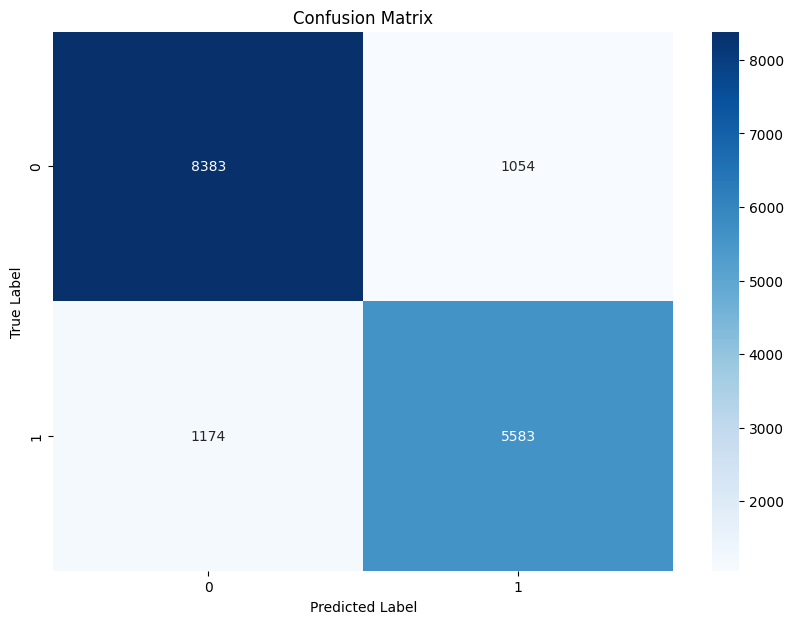

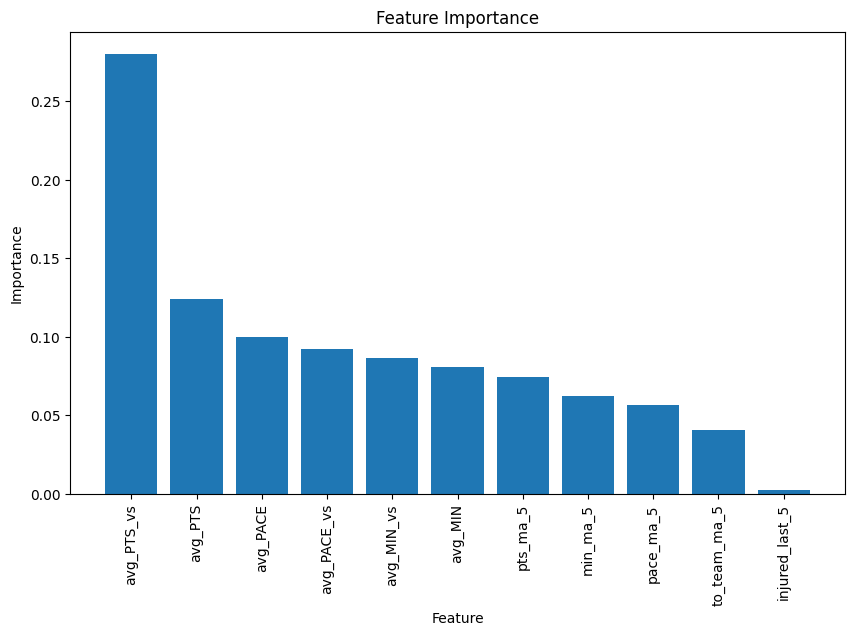

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Feature matrix (X) and target vector (y)
X = df[['avg_PTS', 'pts_ma_5', 'avg_PACE', 'avg_MIN', 'min_ma_5', 'pace_ma_5', 'to_team_ma_5', 'avg_PTS_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y = df['PTS_above_avg']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#Feature Importance
feature_importances = classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = X_train.columns

#Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

TESTING PONTS MODEL ON HIGH VALUE PLAYER

In [ ]:
#TESTING JUST ON STEPHEN CURRY
specific_player_df = df[df['PLAYER_ID'] == 201939]


X_specific_player = specific_player_df[['avg_PTS', 'pts_ma_5', 'avg_PACE', 'avg_MIN', 'min_ma_5', 'pace_ma_5', 'to_team_ma_5', 'avg_PTS_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y_specific_player = specific_player_df['PTS_above_avg']

# Split the data into training and test sets
X_specific_player_train, X_specific_player_test, y_specific_player_train, y_specific_player_test = train_test_split(X_specific_player, y_specific_player, test_size=0.5, random_state=42)

y_specific_player_pred = classifier.predict(X_specific_player_test)


specific_player_accuracy = accuracy_score(y_specific_player_test, y_specific_player_pred)

print(classification_report(y_specific_player_test, y_specific_player_pred))
print("Accuracy:", accuracy_score(y_specific_player_test, y_specific_player_pred))

#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_specific_player_test, y_specific_player_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- avg_PACE
- avg_PTS
- avg_PTS_vs
- pace_ma_5
- pts_ma_5
Feature names seen at fit time, yet now missing:
- ast_ma_5
- avg_AST
- avg_AST_vs
- avg_PACE_team
- pace_team_ma_5


TESTING POINTS MODEL ON LOW VALUE PLAYER

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        21
           1       0.94      0.83      0.88        18

    accuracy                           0.90        39
   macro avg       0.90      0.89      0.90        39
weighted avg       0.90      0.90      0.90        39

Accuracy: 0.8974358974358975


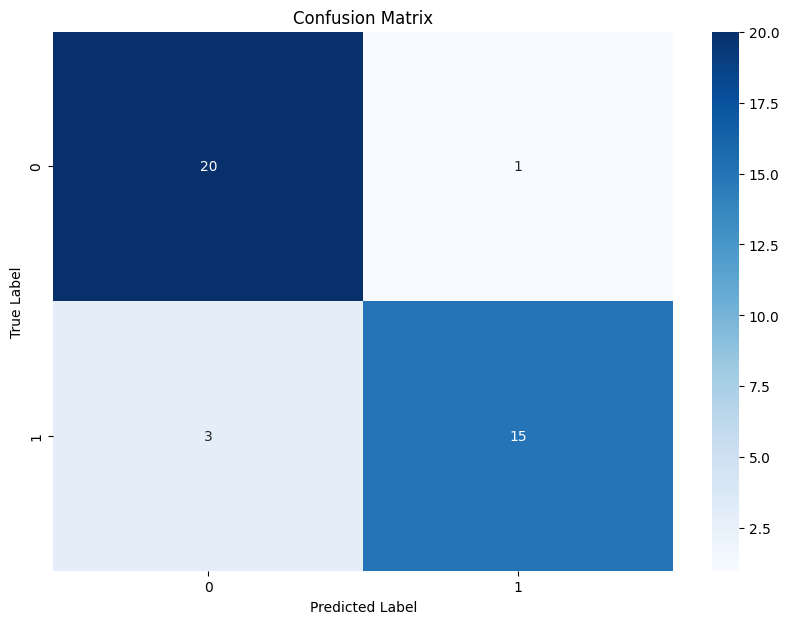

In [ ]:
#TESTING JUST ON ISAIAH HARTENSTEIN
specific_player_df = df[df['PLAYER_ID'] == 1628392]


X_specific_player = specific_player_df[['avg_PTS', 'pts_ma_5', 'avg_PACE', 'avg_MIN', 'min_ma_5', 'pace_ma_5', 'to_team_ma_5', 'avg_PTS_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y_specific_player = specific_player_df['PTS_above_avg']

# Split the data into training and test sets
X_specific_player_train, X_specific_player_test, y_specific_player_train, y_specific_player_test = train_test_split(X_specific_player, y_specific_player, test_size=0.5, random_state=42)

y_specific_player_pred = classifier.predict(X_specific_player_test)


specific_player_accuracy = accuracy_score(y_specific_player_test, y_specific_player_pred)

print(classification_report(y_specific_player_test, y_specific_player_pred))
print("Accuracy:", accuracy_score(y_specific_player_test, y_specific_player_pred))

#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_specific_player_test, y_specific_player_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


ASSISTS

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     10104
           1       0.82      0.86      0.84      6090

    accuracy                           0.88     16194
   macro avg       0.87      0.87      0.87     16194
weighted avg       0.88      0.88      0.88     16194

Accuracy: 0.8762504631344943


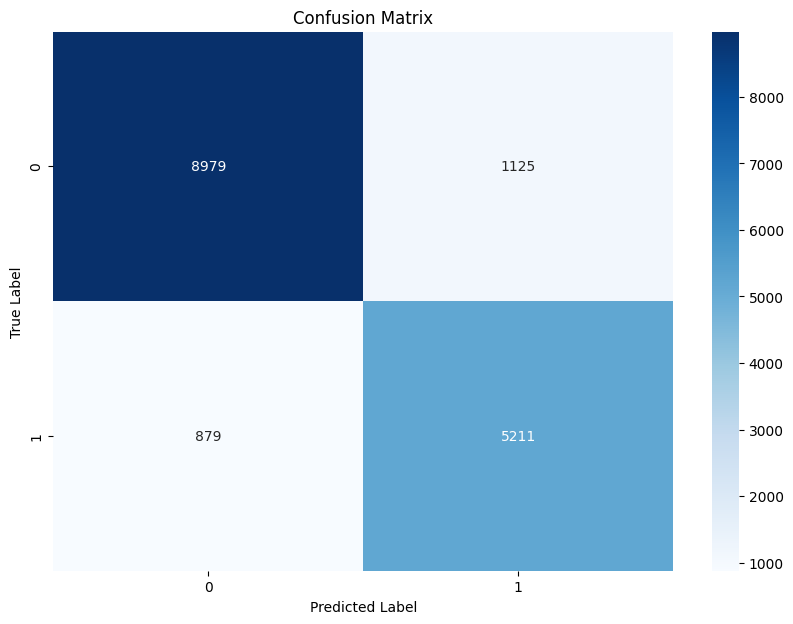

In [ ]:
# Feature matrix (X) and target vector (y)
X = df[['avg_AST', 'ast_ma_5', 'avg_PACE_team', 'avg_MIN', 'min_ma_5', 'pace_team_ma_5', 'to_team_ma_5', 'avg_AST_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y = df['AST_above_avg']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

TESTING ASSISTS MODEL ON HIGH VALUE PLAYER

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.82      1.00      0.90        14

    accuracy                           0.91        35
   macro avg       0.91      0.93      0.91        35
weighted avg       0.93      0.91      0.92        35

Accuracy: 0.9142857142857143


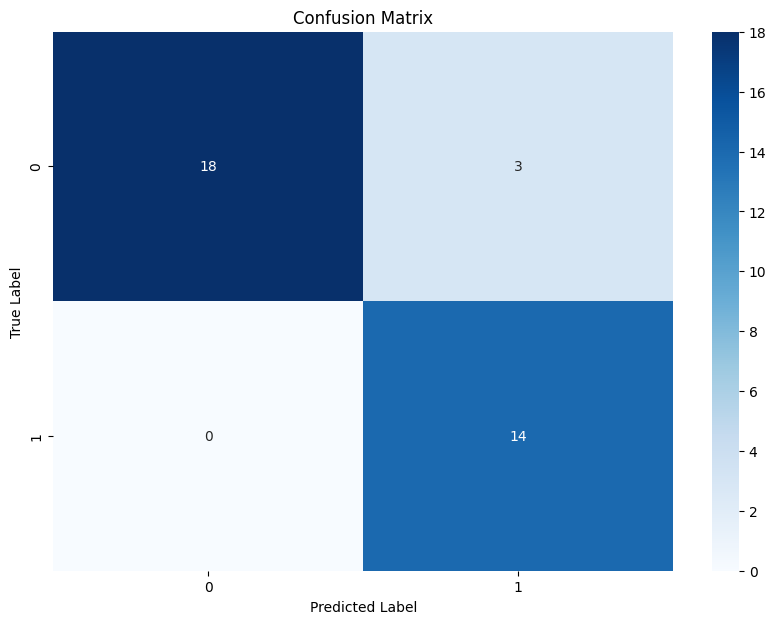

In [ ]:
#TESTING JUST ON TYRESE HALIBURTON
specific_player_df = df[df['PLAYER_ID'] == 1630169]


X_specific_player = specific_player_df[['avg_AST', 'ast_ma_5', 'avg_PACE_team', 'avg_MIN', 'min_ma_5', 'pace_team_ma_5', 'to_team_ma_5', 'avg_AST_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y_specific_player = specific_player_df['AST_above_avg']

# Split the data into training and test sets
X_specific_player_train, X_specific_player_test, y_specific_player_train, y_specific_player_test = train_test_split(X_specific_player, y_specific_player, test_size=0.5, random_state=42)

y_specific_player_pred = classifier.predict(X_specific_player_test)


specific_player_accuracy = accuracy_score(y_specific_player_test, y_specific_player_pred)

print(classification_report(y_specific_player_test, y_specific_player_pred))
print("Accuracy:", accuracy_score(y_specific_player_test, y_specific_player_pred))

#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_specific_player_test, y_specific_player_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

TESTING ASSISTS MODEL ON LOW VALUE PLAYER

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.89      0.89      0.89        19

    accuracy                           0.90        41
   macro avg       0.90      0.90      0.90        41
weighted avg       0.90      0.90      0.90        41

Accuracy: 0.9024390243902439


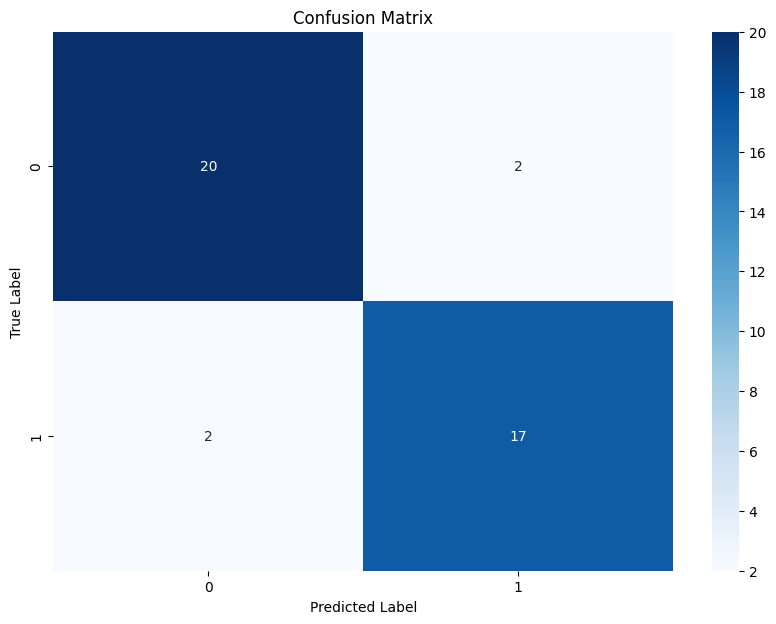

In [ ]:
#TESTING JUST ON JONAS VALENCIUNAS
specific_player_df = df[df['PLAYER_ID'] == 202685]


X_specific_player = specific_player_df[['avg_AST', 'ast_ma_5', 'avg_PACE_team', 'avg_MIN', 'min_ma_5', 'pace_team_ma_5', 'to_team_ma_5', 'avg_AST_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y_specific_player = specific_player_df['AST_above_avg']

# Split the data into training and test sets
X_specific_player_train, X_specific_player_test, y_specific_player_train, y_specific_player_test = train_test_split(X_specific_player, y_specific_player, test_size=0.5, random_state=42)

y_specific_player_pred = classifier.predict(X_specific_player_test)


specific_player_accuracy = accuracy_score(y_specific_player_test, y_specific_player_pred)

print(classification_report(y_specific_player_test, y_specific_player_pred))
print("Accuracy:", accuracy_score(y_specific_player_test, y_specific_player_pred))

#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_specific_player_test, y_specific_player_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

REBOUNDS

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      9550
           1       0.84      0.83      0.83      6644

    accuracy                           0.86     16194
   macro avg       0.86      0.86      0.86     16194
weighted avg       0.86      0.86      0.86     16194

Accuracy: 0.8647647276769174


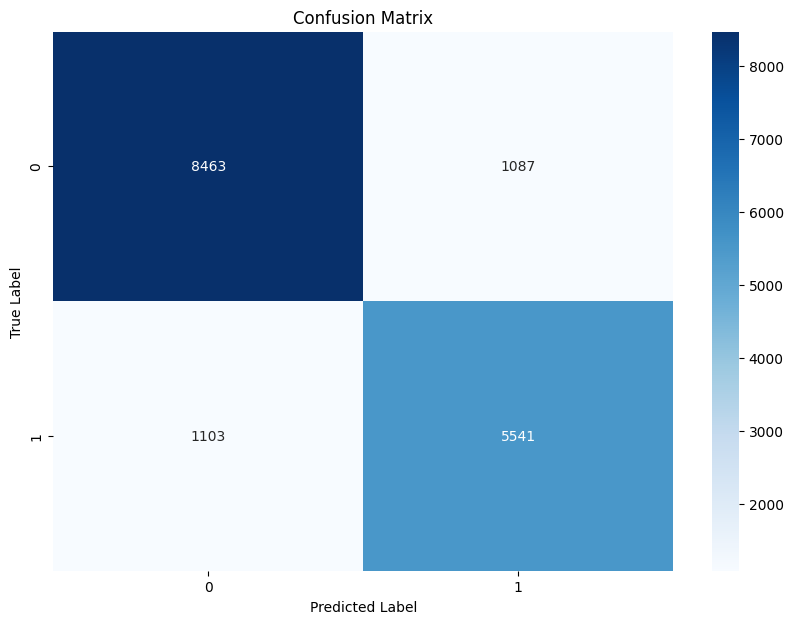

In [ ]:
# Feature matrix (X) and target vector (y)
X = df[['avg_REB', 'reb_ma_5', 'avg_PACE_team', 'avg_MIN', 'min_ma_5', 'pace_team_ma_5', 'avg_REB_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y = df['REB_above_avg']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

TESTING REBOUND MODEL ON HIGH VALUE PLAYER

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.91      0.91      0.91        22

    accuracy                           0.90        41
   macro avg       0.90      0.90      0.90        41
weighted avg       0.90      0.90      0.90        41

Accuracy: 0.9024390243902439


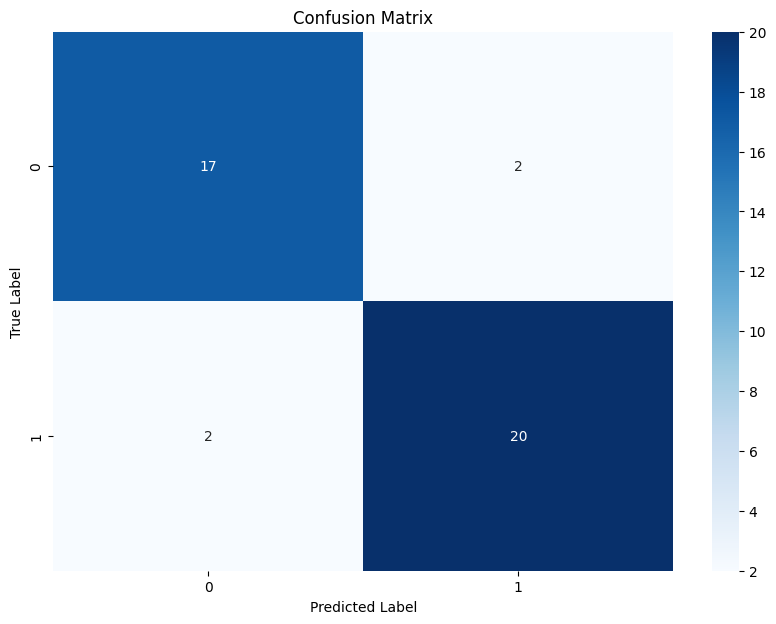

In [ ]:
#TESTING JUST ON DOMANTAS SABONIS
specific_player_df = df[df['PLAYER_ID'] == 1627734]


X_specific_player = specific_player_df[['avg_REB', 'reb_ma_5', 'avg_PACE_team', 'avg_MIN', 'min_ma_5', 'pace_team_ma_5', 'avg_REB_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y_specific_player = specific_player_df['REB_above_avg']

# Split the data into training and test sets
X_specific_player_train, X_specific_player_test, y_specific_player_train, y_specific_player_test = train_test_split(X_specific_player, y_specific_player, test_size=0.5, random_state=42)

y_specific_player_pred = classifier.predict(X_specific_player_test)


specific_player_accuracy = accuracy_score(y_specific_player_test, y_specific_player_pred)

print(classification_report(y_specific_player_test, y_specific_player_pred))
print("Accuracy:", accuracy_score(y_specific_player_test, y_specific_player_pred))

#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_specific_player_test, y_specific_player_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

TESTING REBOUND MODEL ON LOW VALUE PLAYER

In [ ]:
#TESTING JUST ON ERIC GORDON
specific_player_df = df[df['PLAYER_ID'] == 201569
]


X_specific_player = specific_player_df[['avg_REB', 'reb_ma_5', 'avg_PACE_team', 'avg_MIN', 'min_ma_5', 'pace_team_ma_5', 'avg_REB_vs', 'avg_PACE_vs', 'avg_MIN_vs', 'injured_last_5']]
y_specific_player = specific_player_df['REB_above_avg']

# Split the data into training and test sets
X_specific_player_train, X_specific_player_test, y_specific_player_train, y_specific_player_test = train_test_split(X_specific_player, y_specific_player, test_size=0.5, random_state=42)

y_specific_player_pred = classifier.predict(X_specific_player_test)


specific_player_accuracy = accuracy_score(y_specific_player_test, y_specific_player_pred)

print(classification_report(y_specific_player_test, y_specific_player_pred))
print("Accuracy:", accuracy_score(y_specific_player_test, y_specific_player_pred))

#Plot Confusion Matrix
conf_matrix = confusion_matrix(y_specific_player_test, y_specific_player_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()